In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 320.4MB 49kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 320.4MB 53kB/s 


In [ ]:
#Necessary imports
!pip install keras-tuner
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.activations import swish

In [ ]:
!nvidia-smi

Sun Dec  6 20:06:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    41W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Loading the data
(train, trainlabels), (test, testlabels) = cifar10.load_data()

#Converting it to numpy float arrays, with mimnaxscaling
train=np.asarray(train)
test=np.asarray(test)
train=train/255.0
test=test/255.0

#Making some validation data
train, val, trainlabels, vallabels = train_test_split(train, trainlabels, test_size=0.2)

#One-hot encoding the labels for the softmax output
trainlabels=to_categorical(trainlabels)
vallabels=to_categorical(vallabels)
testlabels=to_categorical(testlabels)


In [ ]:
def create_model(hp):
    #variable params
    n_filters1=hp.Choice('conv1filters', values = [32, 64, 128, 256])
    n_filters2=hp.Choice('conv2filters', values = [32, 64, 128, 256])
    kernel_size=hp.Choice('conv_1_kernel', values = [3,5])
    kernel_size2=hp.Choice('conv_2_kernel', values = [3,5])
    n_layer1=hp.Choice('dense1neurons', values = [32, 64, 128, 256])
    n_layer2=hp.Choice('dense2neurons', values = [32, 64, 128, 256])
    dropoutrate = hp.Float('dropoutrate', 0 , 0.5)

    #I make the model here, with one convolutional block
    model = Sequential()
    model.add(Conv2D(n_filters1, kernel_size=kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(n_filters1, kernel_size=kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))

    extrablock = hp.Boolean('extrablock')
    #Additionally i put an extra block in
    if extrablock:
        model.add(Conv2D(n_filters2, kernel_size=kernel_size2, activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(n_filters2, kernel_size=kernel_size2, activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPool2D((2, 2)))

    #After that i flatten the data, and give it to some Dense layers to do the predictions
    model.add(Flatten())
    model.add(Dense(n_layer1, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropoutrate))
    model.add(Dense(n_layer2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    #I compile the model with an adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    return model



In [ ]:
from kerastuner.tuners import Hyperband

#Source: https://github.com/BME-SmartLab-Education/vitmav45/tree/master/12
#I am using kerastuner, becasue the hyperband algorithm is really good for these long trainings, because it can predict the model's performance from a few initial epochs.
tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    factor=5,
    max_epochs=100,
    directory='/content/output',
    project_name='CIFAR10_hyperband')

INFO:tensorflow:Reloading Oracle from existing project /content/output/CIFAR10_hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /content/output/CIFAR10_hyperband/tuner0.json


In [ ]:
#The model has 4*4*2*2*4*4*2 = 2048 parameters to be optimized,
#and the dropout rate, which is a continouos variable between 0.0 and 0.5
tuner.search_space_summary()

Search space summary
Default search space size: 8
conv1filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
conv2filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense1neurons (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dense2neurons (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropoutrate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': None}
extrablock (Boolean)
{'default': False, 'conditions': []}


In [ ]:
from keras.callbacks import EarlyStopping
tuner.search(train, trainlabels, epochs=100, validation_data=(val, vallabels), callbacks=[EarlyStopping(patience=2, restore_best_weights=True), CSVLogger('cifar10-log.csv', separator=';', append=True)])

Trial 19 Complete [00h 00m 53s]
val_accuracy: 0.7384999990463257

Best val_accuracy So Far: 0.7429999709129333
Total elapsed time: 00h 29m 47s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_models = tuner.get_best_models(num_models=50)
for i, model in enumerate(best_models):
    print(i)

In [ ]:
#I make some tests on the models and save the test losses and accuracy values.
losses=[]
accs=[]
for i, model in enumerate(best_models):
        loss, acc = model.evaluate(test, testlabels)
        losses.append(loss)
        accs.append(acc)

313/313 [==============================] - 1s 4ms/step - loss: 1.1959 - accuracy: 0.5697


In [ ]:
#I write the best hparams to a CSV file.
best_hps=tuner.get_best_hyperparameters(num_trials=50)
with open('resultslog3.csv', 'a') as results:
    for idx, hps in enumerate(best_hps):
        results.write(str(hps.get('conv1filters')) + ';')
        results.write(str(hps.get('conv_1_kernel')) +';')
        results.write(str(hps.get('extrablock'))+';')
        results.write(str(hps.get('conv2filters'))+';')
        results.write(str(hps.get('conv_2_kernel'))+';')
        results.write(str(hps.get('dense1neurons'))+';')
        results.write(str(hps.get('dropoutrate'))+';')
        results.write(str(hps.get('dense2neurons'))+';')
        results.write(str(losses[idx])+';')
        results.write(str(accs[idx]))
        results.write('\n')

In [ ]:
#With a little pandas magic, i put a header on the csv file.
import pandas as pd

log=pd.read_csv('resultslog3.csv', delimiter=';', header=None)
log.to_csv('resultswithheader.csv',sep =';',header=['conv1filters', 'conv_1_kernel','extrablock','conv2filters','conv_2_kernel','dense1neurons','dropoutrate','dense2neurons','test_loss','accuracy'])


log=pd.read_csv('resultswithheader.csv', delimiter=';')

In [ ]:
log.head()

,Unnamed: 0,conv1filters,conv_1_kernel,extrablock,conv2filters,conv_2_kernel,dense1neurons,dropoutrate,dense2neurons,test_loss,accuracy
0,0,256,3,True,128,3,128,0.018834,256,0.856391,0.7260
1,1,64,3,True,64,5,128,0.016498,32,0.811395,0.7316
2,2,64,3,True,128,5,64,0.018827,256,0.825573,0.7299
3,3,64,3,True,256,3,64,0.013750,64,0.794985,0.7373
4,4,64,3,True,64,5,128,0.016498,32,0.813230,0.7150


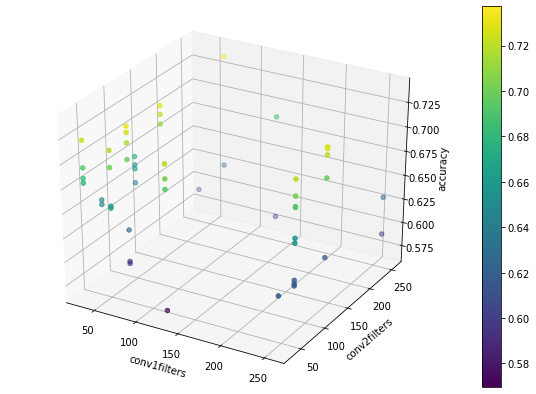

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Source: https://github.com/BME-SmartLab-Education/vitmav45/tree/master/12
#I use some visualisation techniques, which we used in practice lesson.


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot    (111, projection='3d')
p = ax.scatter3D(log.conv1filters, log.conv2filters, log.accuracy, c=log.accuracy)
ax.set_xlabel('conv1filters')
ax.set_ylabel('conv2filters')
ax.set_zlabel('accuracy')
fig.colorbar(p)
plt.show()

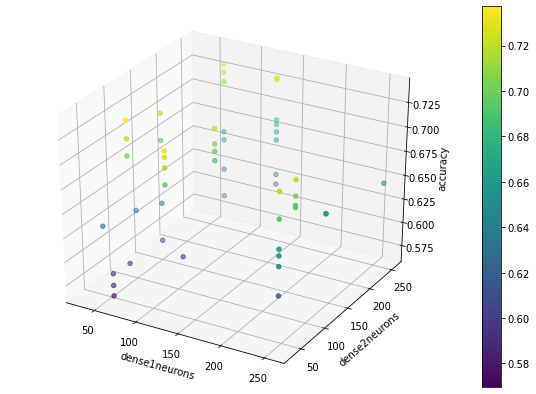

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot    (111, projection='3d')
p = ax.scatter3D(log.dense1neurons, log.dense2neurons, log.accuracy, c=log.accuracy)
ax.set_xlabel('dense1neurons')
ax.set_ylabel('dense2neurons')
ax.set_zlabel('accuracy')
fig.colorbar(p)
plt.show()

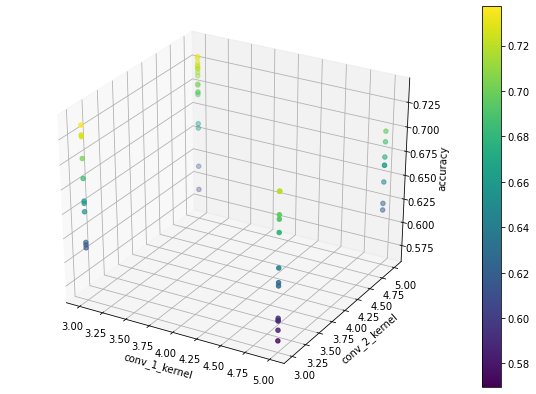

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot    (111, projection='3d')
p = ax.scatter3D(log.conv_1_kernel, log.conv_2_kernel, log.accuracy, c=log.accuracy)
ax.set_xlabel('conv_1_kernel')
ax.set_ylabel('conv_2_kernel')
ax.set_zlabel('accuracy')
fig.colorbar(p)
plt.show()

The main conclusion is that having an extra convolutional block certainly helps a lot. The common thing in the best-performing models is that they had 2 blocks, instead of just one.   
The kernel size on the first convolutional block was 3 in the better performing models, maybe having the first few convolutional layers having a smaller kernel size helps, because they can identify the features on the raw picture better.
On the other hand, the second convolutional block having 3 or 5 kernel size didn't really matter. Having a smaller conv_2_kernel size did almost as good in some cases than having a bigger one.  
The optimal dropout rate between the 2 dense layers for this problem was around 0.015.  
The performance was not really determined by the neuron count of the last 2 dense layers, as seen in the head of the csv file.